이제 예열은 끝났다. 팀별 코드를 만들고 위 함수를 수정해보자.

- accum_bat함수 수정:  1.return의 dataframe에 date 컬럼을 추가하였다. 2. 득점권타율 column 삭제. 
- accum_bat함수 수정:  3. datetime이 NaT로 사라지는 현상발견: 이는 to_datetime에 시리즈를 넣었기에 row값이 저장된 상태로 들어갔다. 다시 인덱싱 필요함(완료).
- avg함수 수정: 1. data오류: HIT가 모든 안타 포함이다. 데이터 전처리 수정 필요함. 이는 avg함수 수정으로 해결함. 

In [1]:
import pandas as pd

In [2]:
df_raw = pd.read_csv("datasets/2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2016.csv")

In [3]:
df_raw

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,PA,AB,RBI,RUN,...,BB,IB,HP,KK,GD,ERR,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN
0,20160401HHLG0,20160401,LG,HH,0,B,47,42,4,5,...,4,0,0,11,0,0,8,0.333333,12,4
1,20160401HHLG0,20160401,HH,LG,0,T,52,46,4,4,...,3,0,0,10,1,2,12,0.200000,15,3
2,20160401HTNC0,20160401,NC,HT,0,B,36,30,5,5,...,5,0,0,9,1,1,7,0.142857,7,1
3,20160401HTNC0,20160401,HT,NC,0,T,38,34,3,4,...,3,0,1,10,1,0,7,0.100000,10,1
4,20160401KTSK0,20160401,SK,KT,0,B,36,36,4,4,...,0,0,0,7,1,1,5,0.375000,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,20161008SSSK0,20161008,SS,SK,0,T,39,36,5,6,...,3,0,0,4,1,2,6,0.250000,8,2
1436,20161009KTNC0,20161009,NC,KT,0,B,41,39,3,4,...,1,0,1,13,0,0,10,0.111111,18,2
1437,20161009KTNC0,20161009,KT,NC,0,T,43,38,5,7,...,3,0,0,7,0,0,9,0.100000,10,1
1438,20161009WOLT0,20161009,LT,WO,0,B,38,36,8,8,...,1,0,1,4,2,0,6,0.416667,12,5


In [4]:
def col_name_kr(df):
    df.rename(columns={'G_ID':'게임키'}, inplace =True)
    df.rename(columns={'GDAY_DS':'일자'}, inplace =True)
    df.rename(columns={'T_ID':'팀코드'}, inplace =True)
    df.rename(columns={'VS_T_ID':'상대팀코드'}, inplace =True)
    df.rename(columns={'HEADER_NO':'더블헤더코드'}, inplace =True)
    df.rename(columns={'TB_SC' :'초말'}, inplace =True)
    df.rename(columns={'PA':'타자'}, inplace =True)
    df.rename(columns={'AB':'타수'}, inplace =True)
    df.rename(columns={'RBI':'타점'}, inplace =True)
    df.rename(columns={'RUN':'득점'}, inplace =True)
    df.rename(columns={'HIT':'안타'}, inplace =True)
    df.rename(columns={'H2':'2루타'}, inplace =True)
    df.rename(columns={'H3':'3루타'}, inplace =True)
    df.rename(columns={'HR':'홈런'}, inplace =True)
    df.rename(columns={'SB':'도루'}, inplace =True)
    df.rename(columns={'CS':'도루실패'}, inplace =True)
    df.rename(columns={'SH' :'희생타'}, inplace =True)
    df.rename(columns={'SF':'희생플라이'}, inplace =True)
    df.rename(columns={'BB':'4구'}, inplace =True)
    df.rename(columns={'IB':'고4'}, inplace =True)
    df.rename(columns={'HP':'사구'}, inplace =True)
    df.rename(columns={'KK':'삼진'}, inplace =True)
    df.rename(columns={'GD':'병살타'}, inplace =True)
    df.rename(columns={'ERR':'실책'}, inplace =True)
    df.rename(columns={'LOB':'잔루'}, inplace =True)
    df.rename(columns={'P_HRA_RT':'득점권타율'}, inplace =True)
    df.rename(columns={'P_AB_CN':'득점권타수'}, inplace =True)
    df.rename(columns={'P_HIT_CN' :'득점권안타'}, inplace =True)

In [5]:
col_name_kr(df_raw)

타율데이터 생성

In [6]:
def avg(df):
    df['1루타'] = df['안타'] - df['2루타']- df['3루타'] - df['홈런']
    df['타율'] = df['안타']/df['타수']
    df['득점권타율'] = df['득점권안타']/df['득점권타수']

시계열 데이터를 위해 누적데이터를 만들어낸다.

In [7]:
def accum_bat(df):
    df_mod = df.loc[:,'타자':]
    df_accum = []
    col = df.columns[6:]
    for i in range(len(df_mod)):
        if i == 0:
            df_accum.append(df_mod.values[i])
        else:
            df_accum.append(df_accum[i-1] + df_mod.values[i])
    df_accum = pd.DataFrame(df_accum, columns=col)
    
    #타율 드랍
    df_accum = df_accum.drop('득점권타율', axis=1)
    return df_accum

In [8]:
def date(df,df_new):
    #일자 컬럼 추가
    ser_date = pd.to_datetime(df['일자'], format='%Y%m%d',errors='ignore')
    ser_date_mod = ser_date.reset_index()
    df_new['일자']=ser_date_mod['일자']

In [9]:
def team_sep(df,team):
    df_new =df[df['팀코드']==team]
    return df_new

In [10]:
df_LG = team_sep(df_raw,'LG')
df_HH = team_sep(df_raw,'HH')
df_NC = team_sep(df_raw,'NC')
df_HT = team_sep(df_raw,'HT')
df_SK = team_sep(df_raw,'SK')
df_KT = team_sep(df_raw,'KT')
df_WO = team_sep(df_raw,'WO')
df_LT = team_sep(df_raw,'LT')
df_SS = team_sep(df_raw,'SS')
df_OB = team_sep(df_raw,'OB')

'''
0    LG
1    HH
2    NC
3    HT
4    SK
5    KT
6    WO
7    LT
8    SS
9    OB
'''

'\n0    LG\n1    HH\n2    NC\n3    HT\n4    SK\n5    KT\n6    WO\n7    LT\n8    SS\n9    OB\n'

In [11]:
df_LG

,게임키,일자,팀코드,상대팀코드,더블헤더코드,초말,타자,타수,타점,득점,...,4구,고4,사구,삼진,병살타,실책,잔루,득점권타율,득점권타수,득점권안타
0,20160401HHLG0,20160401,LG,HH,0,B,47,42,4,5,...,4,0,0,11,0,0,8,0.333333,12,4
10,20160402HHLG0,20160402,LG,HH,0,B,49,40,8,8,...,8,0,1,9,0,1,11,0.300000,10,3
25,20160405LGHT0,20160405,LG,HT,0,T,35,34,1,1,...,1,0,0,9,0,1,7,0.200000,5,1
43,20160407LGHT0,20160407,LG,HT,0,T,43,38,8,8,...,4,0,1,9,0,0,8,0.333333,12,4
57,20160408LGSK0,20160408,LG,SK,0,T,36,33,2,2,...,2,0,1,4,1,3,4,0.200000,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,20161001SKLG0,20161001,LG,SK,0,B,31,26,0,0,...,3,0,1,6,3,0,4,0.000000,4,0
1407,20161003LGSS0,20161003,LG,SS,0,T,46,40,10,10,...,2,0,2,6,1,0,9,0.384615,13,5
1409,20161004LGSS0,20161004,LG,SS,0,T,35,32,4,4,...,2,0,0,8,1,0,4,0.200000,5,1
1421,20161006LGLT0,20161006,LG,LT,0,T,42,31,4,4,...,9,0,0,6,1,0,11,0.272727,11,3


In [12]:
LG_accum = accum_bat(df_LG)
HH_accum = accum_bat(df_HH)
NC_accum = accum_bat(df_NC)
HT_accum = accum_bat(df_HT)
SK_accum = accum_bat(df_SK)
KT_accum = accum_bat(df_KT)
WO_accum = accum_bat(df_WO)
LT_accum = accum_bat(df_LT)
SS_accum = accum_bat(df_SS)
OB_accum = accum_bat(df_OB)

In [13]:
LG_accum

,타자,타수,타점,득점,안타,2루타,3루타,홈런,도루,도루실패,...,희생플라이,4구,고4,사구,삼진,병살타,실책,잔루,득점권타수,득점권안타
0,47.0,42.0,4.0,5.0,9.0,2.0,0.0,1.0,2.0,1.0,...,0.0,4.0,0.0,0.0,11.0,0.0,0.0,8.0,12.0,4.0
1,96.0,82.0,12.0,13.0,21.0,4.0,1.0,2.0,3.0,3.0,...,0.0,12.0,0.0,1.0,20.0,0.0,1.0,19.0,22.0,7.0
2,131.0,116.0,13.0,14.0,28.0,4.0,1.0,2.0,4.0,3.0,...,0.0,13.0,0.0,1.0,29.0,0.0,2.0,26.0,27.0,8.0
3,174.0,154.0,21.0,22.0,39.0,5.0,1.0,4.0,6.0,3.0,...,0.0,17.0,0.0,2.0,38.0,0.0,2.0,34.0,39.0,12.0
4,210.0,187.0,23.0,24.0,43.0,5.0,1.0,5.0,6.0,3.0,...,0.0,19.0,0.0,3.0,42.0,1.0,5.0,38.0,44.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,5608.0,4919.0,725.0,767.0,1430.0,233.0,26.0,114.0,118.0,68.0,...,51.0,506.0,10.0,70.0,954.0,88.0,85.0,1086.0,1375.0,392.0
140,5654.0,4959.0,735.0,777.0,1445.0,237.0,26.0,116.0,119.0,68.0,...,52.0,508.0,10.0,72.0,960.0,89.0,85.0,1095.0,1388.0,397.0
141,5689.0,4991.0,739.0,781.0,1454.0,237.0,26.0,118.0,120.0,70.0,...,52.0,510.0,10.0,72.0,968.0,90.0,85.0,1099.0,1393.0,398.0
142,5731.0,5022.0,743.0,785.0,1461.0,237.0,26.0,118.0,121.0,70.0,...,53.0,519.0,10.0,72.0,974.0,91.0,85.0,1110.0,1404.0,401.0


In [14]:
avg(LG_accum)
avg(HH_accum)
avg(NC_accum)
avg(HT_accum)
avg(SK_accum)
avg(KT_accum)
avg(WO_accum)
avg(LT_accum)
avg(SS_accum)
avg(OB_accum)


In [15]:
LG_accum

,타자,타수,타점,득점,안타,2루타,3루타,홈런,도루,도루실패,...,사구,삼진,병살타,실책,잔루,득점권타수,득점권안타,1루타,타율,득점권타율
0,47.0,42.0,4.0,5.0,9.0,2.0,0.0,1.0,2.0,1.0,...,0.0,11.0,0.0,0.0,8.0,12.0,4.0,6.0,0.214286,0.333333
1,96.0,82.0,12.0,13.0,21.0,4.0,1.0,2.0,3.0,3.0,...,1.0,20.0,0.0,1.0,19.0,22.0,7.0,14.0,0.256098,0.318182
2,131.0,116.0,13.0,14.0,28.0,4.0,1.0,2.0,4.0,3.0,...,1.0,29.0,0.0,2.0,26.0,27.0,8.0,21.0,0.241379,0.296296
3,174.0,154.0,21.0,22.0,39.0,5.0,1.0,4.0,6.0,3.0,...,2.0,38.0,0.0,2.0,34.0,39.0,12.0,29.0,0.253247,0.307692
4,210.0,187.0,23.0,24.0,43.0,5.0,1.0,5.0,6.0,3.0,...,3.0,42.0,1.0,5.0,38.0,44.0,13.0,32.0,0.229947,0.295455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,5608.0,4919.0,725.0,767.0,1430.0,233.0,26.0,114.0,118.0,68.0,...,70.0,954.0,88.0,85.0,1086.0,1375.0,392.0,1057.0,0.290709,0.285091
140,5654.0,4959.0,735.0,777.0,1445.0,237.0,26.0,116.0,119.0,68.0,...,72.0,960.0,89.0,85.0,1095.0,1388.0,397.0,1066.0,0.291389,0.286023
141,5689.0,4991.0,739.0,781.0,1454.0,237.0,26.0,118.0,120.0,70.0,...,72.0,968.0,90.0,85.0,1099.0,1393.0,398.0,1073.0,0.291324,0.285714
142,5731.0,5022.0,743.0,785.0,1461.0,237.0,26.0,118.0,121.0,70.0,...,72.0,974.0,91.0,85.0,1110.0,1404.0,401.0,1080.0,0.290920,0.285613


혹시 일자랑 타율만 가지고 RNN돌려도 될까?

In [16]:
date(df_LG,LG_accum)
date(df_HH,HH_accum)
date(df_NC,NC_accum)
date(df_HT,HT_accum)
date(df_SK,SK_accum)
date(df_KT,KT_accum)
date(df_WO,WO_accum)
date(df_LT,LT_accum)
date(df_SS,SS_accum)
date(df_OB,OB_accum)

In [17]:
LG_accum

,타자,타수,타점,득점,안타,2루타,3루타,홈런,도루,도루실패,...,삼진,병살타,실책,잔루,득점권타수,득점권안타,1루타,타율,득점권타율,일자
0,47.0,42.0,4.0,5.0,9.0,2.0,0.0,1.0,2.0,1.0,...,11.0,0.0,0.0,8.0,12.0,4.0,6.0,0.214286,0.333333,2016-04-01
1,96.0,82.0,12.0,13.0,21.0,4.0,1.0,2.0,3.0,3.0,...,20.0,0.0,1.0,19.0,22.0,7.0,14.0,0.256098,0.318182,2016-04-02
2,131.0,116.0,13.0,14.0,28.0,4.0,1.0,2.0,4.0,3.0,...,29.0,0.0,2.0,26.0,27.0,8.0,21.0,0.241379,0.296296,2016-04-05
3,174.0,154.0,21.0,22.0,39.0,5.0,1.0,4.0,6.0,3.0,...,38.0,0.0,2.0,34.0,39.0,12.0,29.0,0.253247,0.307692,2016-04-07
4,210.0,187.0,23.0,24.0,43.0,5.0,1.0,5.0,6.0,3.0,...,42.0,1.0,5.0,38.0,44.0,13.0,32.0,0.229947,0.295455,2016-04-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,5608.0,4919.0,725.0,767.0,1430.0,233.0,26.0,114.0,118.0,68.0,...,954.0,88.0,85.0,1086.0,1375.0,392.0,1057.0,0.290709,0.285091,2016-10-01
140,5654.0,4959.0,735.0,777.0,1445.0,237.0,26.0,116.0,119.0,68.0,...,960.0,89.0,85.0,1095.0,1388.0,397.0,1066.0,0.291389,0.286023,2016-10-03
141,5689.0,4991.0,739.0,781.0,1454.0,237.0,26.0,118.0,120.0,70.0,...,968.0,90.0,85.0,1099.0,1393.0,398.0,1073.0,0.291324,0.285714,2016-10-04
142,5731.0,5022.0,743.0,785.0,1461.0,237.0,26.0,118.0,121.0,70.0,...,974.0,91.0,85.0,1110.0,1404.0,401.0,1080.0,0.290920,0.285613,2016-10-06


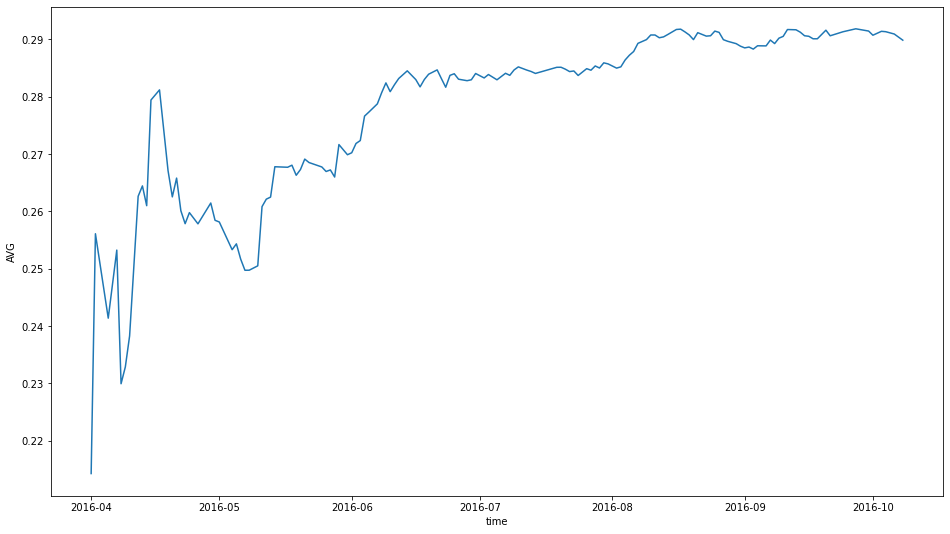

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,9))
sns.lineplot( x=LG_accum['일자'], y=LG_accum['타율'])
plt.xlabel('time')
plt.ylabel('AVG')
plt.show()

무엇을 피쳐로 사용할까? 아마 경기당 기록으로 바꿔야 좋을것 같다.

In [19]:
def per_fit(df):
    #타자부터 득점권안타까지 경기당 기록으로 change
    for i in range(len(df)):
        df.loc[i,:'득점권안타'] = df.loc[i,:'득점권안타']/(i+1)

scaling 필요

In [20]:
def scale(df):
    from sklearn.preprocessing import MinMaxScaler
    scale_cols = list(df.columns[:-3])
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(df[scale_cols])
    df[scale_cols] = scaled_df
    #일자, 타율, 득점권 타율 제외


0    LG
1    HH
2    NC
3    HT
4    SK
5    KT
6    WO
7    LT
8    SS
9    OB


In [21]:
per_fit(LG_accum)
per_fit(HH_accum)
per_fit(NC_accum)
per_fit(HT_accum)
per_fit(SK_accum)
per_fit(KT_accum)
per_fit(WO_accum)
per_fit(LT_accum)
per_fit(SS_accum)
per_fit(OB_accum)

scale(LG_accum)
scale(HH_accum)
scale(NC_accum)
scale(HT_accum)
scale(SK_accum)
scale(KT_accum)
scale(WO_accum)
scale(LT_accum)
scale(SS_accum)
scale(OB_accum)

In [22]:
LG_accum

,타자,타수,타점,득점,안타,2루타,3루타,홈런,도루,도루실패,...,삼진,병살타,실책,잔루,득점권타수,득점권안타,1루타,타율,득점권타율,일자
0,0.886544,1.000000,0.000000,0.250000,0.250000,1.000000,0.000000,0.500000,1.000000,0.540541,...,1.000000,0.000000,0.000000,0.322581,1.000000,1.000000,0.000000,0.214286,0.333333,2016-04-01
1,1.000000,0.872274,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.636364,1.000000,...,0.764398,0.000000,0.500000,1.000000,0.758621,0.750000,0.007435,0.256098,0.318182,2016-04-02
2,0.508355,0.574247,0.166667,0.083333,0.416667,0.333333,0.666667,0.000000,0.515152,0.540541,...,0.685864,0.000000,0.666667,0.623656,0.275862,0.333333,0.013941,0.241379,0.296296,2016-04-05
3,0.489446,0.552960,0.625000,0.500000,0.625000,0.250000,0.500000,0.500000,0.636364,0.310811,...,0.646597,0.000000,0.500000,0.548387,0.456897,0.500000,0.021375,0.253247,0.307692,2016-04-07
4,0.319261,0.412461,0.300000,0.150000,0.050000,0.000000,0.400000,0.500000,0.418182,0.172973,...,0.387435,0.300000,1.000000,0.141935,0.227586,0.300000,0.024164,0.229947,0.295455,2016-04-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.098832,0.123253,0.589286,0.489286,0.857143,0.664286,0.371429,0.221429,0.158442,0.067954,...,0.013837,0.942857,0.607143,0.212903,0.474138,0.400000,0.976766,0.290709,0.285091,2016-10-01
140,0.103613,0.127660,0.606383,0.505319,0.874113,0.680851,0.368794,0.234043,0.159252,0.064788,...,0.012476,0.946809,0.602837,0.216884,0.479579,0.407801,0.985130,0.291389,0.286023,2016-10-03
141,0.099539,0.124808,0.602113,0.500000,0.869718,0.669014,0.366197,0.246479,0.160051,0.074610,...,0.014453,0.950704,0.598592,0.204907,0.471345,0.401408,0.991636,0.291324,0.285714,2016-10-04
142,0.101076,0.121103,0.597902,0.494755,0.858392,0.657343,0.363636,0.237762,0.160839,0.071442,...,0.013107,0.954545,0.594406,0.215204,0.473354,0.402098,0.998141,0.290920,0.285613,2016-10-06


전체 데이터로 병합

In [43]:
OB_accum

,타자,타수,타점,득점,안타,2루타,3루타,홈런,도루,도루실패,...,삼진,병살타,실책,잔루,득점권타수,득점권안타,1루타,타율,득점권타율,일자
0,0.000000,0.000000,0.079422,0.310954,0.075786,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.886792,0.000000,0.000000,0.000000,0.000000,0.000000,0.258065,0.142857,2016-04-01
1,0.550000,0.801676,0.476534,0.505300,0.682070,1.000000,0.000000,0.583333,0.666667,0.288462,...,0.375000,0.886792,0.000000,0.588235,1.000000,0.446602,0.004970,0.289855,0.173913,2016-04-02
2,0.513333,0.305400,0.476534,0.570082,0.277880,0.777778,1.000000,0.166667,0.777778,0.525641,...,0.416667,0.295597,0.000000,0.784314,0.666667,0.446602,0.008946,0.268041,0.200000,2016-04-05
3,0.110000,0.171788,0.178700,0.213781,0.000000,0.583333,0.750000,0.166667,0.500000,0.288462,...,0.625000,0.000000,0.000000,0.661765,0.777778,0.334951,0.012922,0.244094,0.166667,2016-04-06
4,0.220000,0.366480,0.000000,0.000000,0.136414,0.533333,0.600000,0.000000,0.333333,0.146154,...,0.800000,0.177358,0.000000,0.882353,0.711111,0.267961,0.021869,0.251534,0.156863,2016-04-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.779429,0.911293,0.916194,0.899546,0.818484,0.654762,0.535714,0.392857,0.071429,0.034341,...,0.771429,0.608086,0.780827,0.779412,0.617460,0.890014,0.973161,0.298754,0.306063,2016-09-28
140,0.772340,0.908079,0.901810,0.884345,0.808917,0.650118,0.531915,0.391253,0.068558,0.031097,...,0.781915,0.610063,0.810004,0.780142,0.616233,0.880534,0.978131,0.297972,0.304064,2016-09-29
141,0.771549,0.908136,0.898815,0.880307,0.803754,0.650235,0.528169,0.389671,0.065728,0.027898,...,0.779930,0.599522,0.815789,0.780862,0.615023,0.880624,0.983101,0.297482,0.304254,2016-10-03
142,0.773846,0.912998,0.898639,0.879043,0.805023,0.655012,0.524476,0.388112,0.062937,0.024744,...,0.784965,0.601531,0.810085,0.781571,0.615385,0.883835,0.989066,0.297422,0.304939,2016-10-04


In [44]:
test

,타자,타수,타점,득점,안타,2루타,3루타,홈런,도루,도루실패,...,삼진,병살타,실책,잔루,득점권타수,득점권안타,1루타,타율,득점권타율,일자
1296,0.000000,0.000000,0.079422,0.310954,0.075786,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.886792,0.000000,0.000000,0.000000,0.000000,0.000000,0.258065,0.142857,2016-04-01
1297,0.550000,0.801676,0.476534,0.505300,0.682070,1.000000,0.000000,0.583333,0.666667,0.288462,...,0.375000,0.886792,0.000000,0.588235,1.000000,0.446602,0.004970,0.289855,0.173913,2016-04-02
1298,0.513333,0.305400,0.476534,0.570082,0.277880,0.777778,1.000000,0.166667,0.777778,0.525641,...,0.416667,0.295597,0.000000,0.784314,0.666667,0.446602,0.008946,0.268041,0.200000,2016-04-05
1299,0.110000,0.171788,0.178700,0.213781,0.000000,0.583333,0.750000,0.166667,0.500000,0.288462,...,0.625000,0.000000,0.000000,0.661765,0.777778,0.334951,0.012922,0.244094,0.166667,2016-04-06
1300,0.220000,0.366480,0.000000,0.000000,0.136414,0.533333,0.600000,0.000000,0.333333,0.146154,...,0.800000,0.177358,0.000000,0.882353,0.711111,0.267961,0.021869,0.251534,0.156863,2016-04-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.779429,0.911293,0.916194,0.899546,0.818484,0.654762,0.535714,0.392857,0.071429,0.034341,...,0.771429,0.608086,0.780827,0.779412,0.617460,0.890014,0.973161,0.298754,0.306063,2016-09-28
1436,0.772340,0.908079,0.901810,0.884345,0.808917,0.650118,0.531915,0.391253,0.068558,0.031097,...,0.781915,0.610063,0.810004,0.780142,0.616233,0.880534,0.978131,0.297972,0.304064,2016-09-29
1437,0.771549,0.908136,0.898815,0.880307,0.803754,0.650235,0.528169,0.389671,0.065728,0.027898,...,0.779930,0.599522,0.815789,0.780862,0.615023,0.880624,0.983101,0.297482,0.304254,2016-10-03
1438,0.773846,0.912998,0.898639,0.879043,0.805023,0.655012,0.524476,0.388112,0.062937,0.024744,...,0.784965,0.601531,0.810085,0.781571,0.615385,0.883835,0.989066,0.297422,0.304939,2016-10-04


In [23]:
df = pd.concat([LG_accum, HH_accum, NC_accum, HT_accum, SK_accum, KT_accum, WO_accum, LT_accum, SS_accum, OB_accum], ignore_index=True)

In [24]:
df

,타자,타수,타점,득점,안타,2루타,3루타,홈런,도루,도루실패,...,삼진,병살타,실책,잔루,득점권타수,득점권안타,1루타,타율,득점권타율,일자
0,0.886544,1.000000,0.000000,0.250000,0.250000,1.000000,0.000000,0.500000,1.000000,0.540541,...,1.000000,0.000000,0.000000,0.322581,1.000000,1.000000,0.000000,0.214286,0.333333,2016-04-01
1,1.000000,0.872274,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.636364,1.000000,...,0.764398,0.000000,0.500000,1.000000,0.758621,0.750000,0.007435,0.256098,0.318182,2016-04-02
2,0.508355,0.574247,0.166667,0.083333,0.416667,0.333333,0.666667,0.000000,0.515152,0.540541,...,0.685864,0.000000,0.666667,0.623656,0.275862,0.333333,0.013941,0.241379,0.296296,2016-04-05
3,0.489446,0.552960,0.625000,0.500000,0.625000,0.250000,0.500000,0.500000,0.636364,0.310811,...,0.646597,0.000000,0.500000,0.548387,0.456897,0.500000,0.021375,0.253247,0.307692,2016-04-07
4,0.319261,0.412461,0.300000,0.150000,0.050000,0.000000,0.400000,0.500000,0.418182,0.172973,...,0.387435,0.300000,1.000000,0.141935,0.227586,0.300000,0.024164,0.229947,0.295455,2016-04-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.779429,0.911293,0.916194,0.899546,0.818484,0.654762,0.535714,0.392857,0.071429,0.034341,...,0.771429,0.608086,0.780827,0.779412,0.617460,0.890014,0.973161,0.298754,0.306063,2016-09-28
1436,0.772340,0.908079,0.901810,0.884345,0.808917,0.650118,0.531915,0.391253,0.068558,0.031097,...,0.781915,0.610063,0.810004,0.780142,0.616233,0.880534,0.978131,0.297972,0.304064,2016-09-29
1437,0.771549,0.908136,0.898815,0.880307,0.803754,0.650235,0.528169,0.389671,0.065728,0.027898,...,0.779930,0.599522,0.815789,0.780862,0.615023,0.880624,0.983101,0.297482,0.304254,2016-10-03
1438,0.773846,0.912998,0.898639,0.879043,0.805023,0.655012,0.524476,0.388112,0.062937,0.024744,...,0.784965,0.601531,0.810085,0.781571,0.615385,0.883835,0.989066,0.297422,0.304939,2016-10-04


타율을 label로 설정

In [25]:
TEST_SIZE = 144

In [26]:
train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]

In [27]:
# 데이터를 묶어서 처리하는 함수
def make_dateset(data, label, window_size=10):
    import numpy as np
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [28]:
feature_cols = df.columns[:-3]
label_cols = ['타율']

In [29]:
train_feature, train_label = make_dateset(train[feature_cols], train[label_cols],12)
test_feature, test_label = make_dateset(test[feature_cols], test[label_cols],12)

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(
    train_feature, train_label, test_size=0.1)

In [31]:
x_train.shape, x_valid.shape

((1155, 12, 22), (129, 12, 22))

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM

In [33]:
model = Sequential()

In [34]:
model.add(LSTM(16, activation='relu',
              input_shape=(train_feature.shape[1], train_feature.shape[2])))
model.add(Dense(1))

In [35]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=12)

In [37]:
hist = model.fit(x_train, y_train, epochs=200, batch_size=16,
                validation_data=(x_valid, y_valid), callbacks=[early_stop])

Train on 1155 samples, validate on 129 samples
Epoch 1/200
1155/1155 [==============================] - 2s 2ms/sample - loss: 0.0306 - mae: 0.1258 - val_loss: 0.0046 - val_mae: 0.0520
Epoch 2/200
1155/1155 [==============================] - 1s 553us/sample - loss: 0.0029 - mae: 0.0408 - val_loss: 0.0015 - val_mae: 0.0282
Epoch 3/200
1155/1155 [==============================] - 1s 561us/sample - loss: 0.0012 - mae: 0.0262 - val_loss: 9.0203e-04 - val_mae: 0.0226
Epoch 4/200
1155/1155 [==============================] - 1s 516us/sample - loss: 8.1103e-04 - mae: 0.0210 - val_loss: 6.8304e-04 - val_mae: 0.0194
Epoch 5/200
1155/1155 [==============================] - 1s 525us/sample - loss: 6.0629e-04 - mae: 0.0176 - val_loss: 5.7098e-04 - val_mae: 0.0179
Epoch 6/200
1155/1155 [==============================] - 1s 538us/sample - loss: 4.8816e-04 - mae: 0.0157 - val_loss: 4.7076e-04 - val_mae: 0.0158
Epoch 7/200
1155/1155 [==============================] - 1s 536us/sample - loss: 4.1044e-04 -

1155/1155 [==============================] - 1s 566us/sample - loss: 4.2216e-05 - mae: 0.0039 - val_loss: 3.2683e-05 - val_mae: 0.0040
Epoch 57/200
1155/1155 [==============================] - 1s 521us/sample - loss: 4.4182e-05 - mae: 0.0042 - val_loss: 3.2817e-05 - val_mae: 0.0040
Epoch 58/200
1155/1155 [==============================] - 1s 528us/sample - loss: 3.9470e-05 - mae: 0.0039 - val_loss: 2.9790e-05 - val_mae: 0.0037
Epoch 59/200
1155/1155 [==============================] - 1s 562us/sample - loss: 3.8652e-05 - mae: 0.0038 - val_loss: 2.8703e-05 - val_mae: 0.0036
Epoch 60/200
1155/1155 [==============================] - 1s 543us/sample - loss: 4.0940e-05 - mae: 0.0040 - val_loss: 2.9476e-05 - val_mae: 0.0037
Epoch 61/200
1155/1155 [==============================] - 1s 556us/sample - loss: 3.7425e-05 - mae: 0.0037 - val_loss: 2.9471e-05 - val_mae: 0.0038
Epoch 62/200
1155/1155 [==============================] - 1s 560us/sample - loss: 3.8395e-05 - mae: 0.0038 - val_loss: 3.0687

1155/1155 [==============================] - 1s 537us/sample - loss: 2.5316e-05 - mae: 0.0030 - val_loss: 3.8190e-05 - val_mae: 0.0045
Epoch 112/200
1155/1155 [==============================] - 1s 536us/sample - loss: 2.5103e-05 - mae: 0.0030 - val_loss: 6.0232e-05 - val_mae: 0.0067
Epoch 113/200
1155/1155 [==============================] - 1s 560us/sample - loss: 3.1236e-05 - mae: 0.0036 - val_loss: 2.8162e-05 - val_mae: 0.0037


In [38]:
pred = model.predict(test_feature)

In [39]:
model.evaluate(test_feature, test_label)

132/132 [==============================] - 0s 113us/sample - loss: 8.4052e-04 - mae: 0.0279


[0.0008405163517278252, 0.02793161]

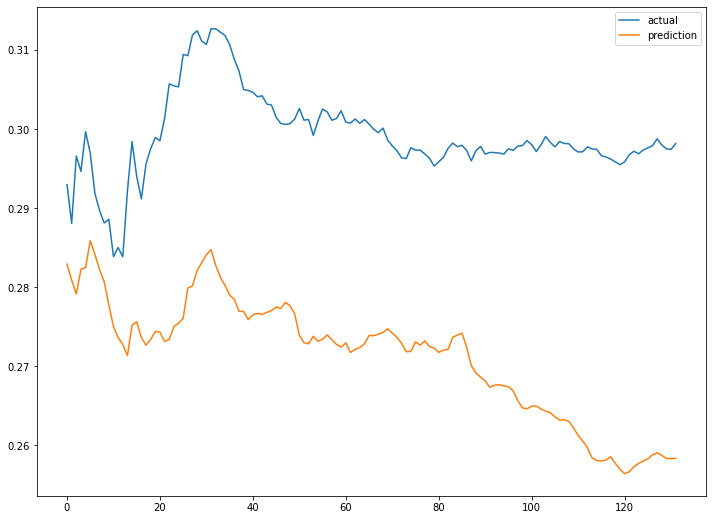

In [40]:
plt.figure(figsize=(12,9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()